In [19]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

class ClassificationResult:
    def __init__(self, model=None, pre_processing=None, sentiment=None, training_set_id=None):
        self.model = model
        self.pre_processing = pre_processing
        self.sentiment = sentiment
        self.training_set_id = training_set_id
        self.confusion_matrix = None
        self.class_report = {}

    def load_from_file(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Parse confusion matrix
        matrix_start = 0
        matrix_end = matrix_start + 2
        self.confusion_matrix = [list(map(int, line.strip('[] \n').split())) for line in lines[matrix_start:matrix_end]]

        # Parse classification report
        report_start = matrix_end + 2
        for line in lines[report_start:]:
            parts = line.strip().split()
            if len(parts) == 5:  # Class line
                self.class_report[parts[0]] = {
                    'precision': float(parts[1]),
                    'recall': float(parts[2]),
                    'f1-score': float(parts[3]),
                    'support': int(parts[4])
                }
            elif len(parts) == 6:  # Accuracy, macro avg, weighted avg lines
                self.class_report[parts[0] + '_' + parts[1]] = {
                    'precision': float(parts[2]),
                    'recall': float(parts[3]),
                    'f1-score': float(parts[4]),
                    'support': int(parts[5])
                }

class ReportComparison:
    def __init__(self):
        self.reports = []

    def load_files(self, file_dir):
        # Iterate over all report files in the directory
        for report_file_path in glob.glob(f"{file_dir}/*/report_*.txt"):
            # Extract model, pre-processing, sentiment, and training set id from the file path
            parts = os.path.basename(report_file_path).split('_')
            model = os.path.basename(os.path.dirname(report_file_path))
            pre_processing = parts[1][:2]
            sentiment = parts[1][2:5]
            training_set_id = parts[1][5:]

            report = ClassificationResult(model=model, pre_processing=pre_processing, sentiment=sentiment, training_set_id=training_set_id)
            report.load_from_file(report_file_path)
            self.reports.append(report)

    def generate_table(self):
        data = []
        for report in self.reports:
            row = {'model': report.model, 'pre_processing': report.pre_processing, 'sentiment': report.sentiment, 'training_set_id': report.training_set_id}
            for class_name, class_report in report.class_report.items():
                for metric_name, metric_value in class_report.items():
                    if metric_name != 'support':
                        row[f'{class_name}_{metric_name}'] = metric_value
            data.append(row)
        df = pd.DataFrame(data)
        return df

    def generate_graphs(self, metric, class_name):
        models = list(set([report.model for report in self.reports]))
        pre_processings = list(set([report.pre_processing for report in self.reports]))
        sentiments = list(set([report.sentiment for report in self.reports]))
        training_set_ids = sorted(list(set([report.training_set_id for report in self.reports])))
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
        # Initialize the figure and axes
        fig, ax = plt.subplots(len(pre_processings), len(sentiments), figsize=(18, 12))
    
        # Generate the graphs
        for i, pre_processing in enumerate(pre_processings):
            for j, sentiment in enumerate(sentiments):
                for k, model in enumerate(models):
                    values = [report.class_report[class_name][metric] for report in self.reports if report.model == model and report.pre_processing == pre_processing and report.sentiment == sentiment and report.training_set_id in training_set_ids]
                    x_coords = [x for x in range(k, len(training_set_ids)*len(models), len(models))]
                    if len(x_coords) == len(values):
                        ax[i, j].bar(x_coords, values, color=colors[k % len(colors)], label=model, width=1)
                ax[i, j].set_title(f'{pre_processing} {sentiment}')
                ax[i, j].set_xlabel('Training set id')
                ax[i, j].set_ylabel(metric)
                ax[i, j].legend()
    
        plt.tight_layout()
        plt.show()



In [17]:
ROOT_DIR = ""
REP_DIR = os.path.join(ROOT_DIR, "reports")

          model pre_processing sentiment training_set_id  OBJ_precision  \
0           ADA             LM       NEG       0.csv.txt           0.99   
1           ADA             LM       NEG       2.csv.txt           0.99   
2           ADA             LM       NEG       4.csv.txt           0.99   
3           ADA             LM       NEG       6.csv.txt           0.99   
4           ADA             LM       POS       0.csv.txt           0.99   
..          ...            ...       ...             ...            ...   
67  Transformer             LM       NEG       6.csv.txt            NaN   
68  Transformer             LM       POS       0.csv.txt            NaN   
69  Transformer             LM       POS       2.csv.txt            NaN   
70  Transformer             LM       POS       4.csv.txt            NaN   
71  Transformer             LM       POS       6.csv.txt            NaN   

    OBJ_recall  OBJ_f1-score  NEG_precision  NEG_recall  NEG_f1-score  ...  \
0         1.00       

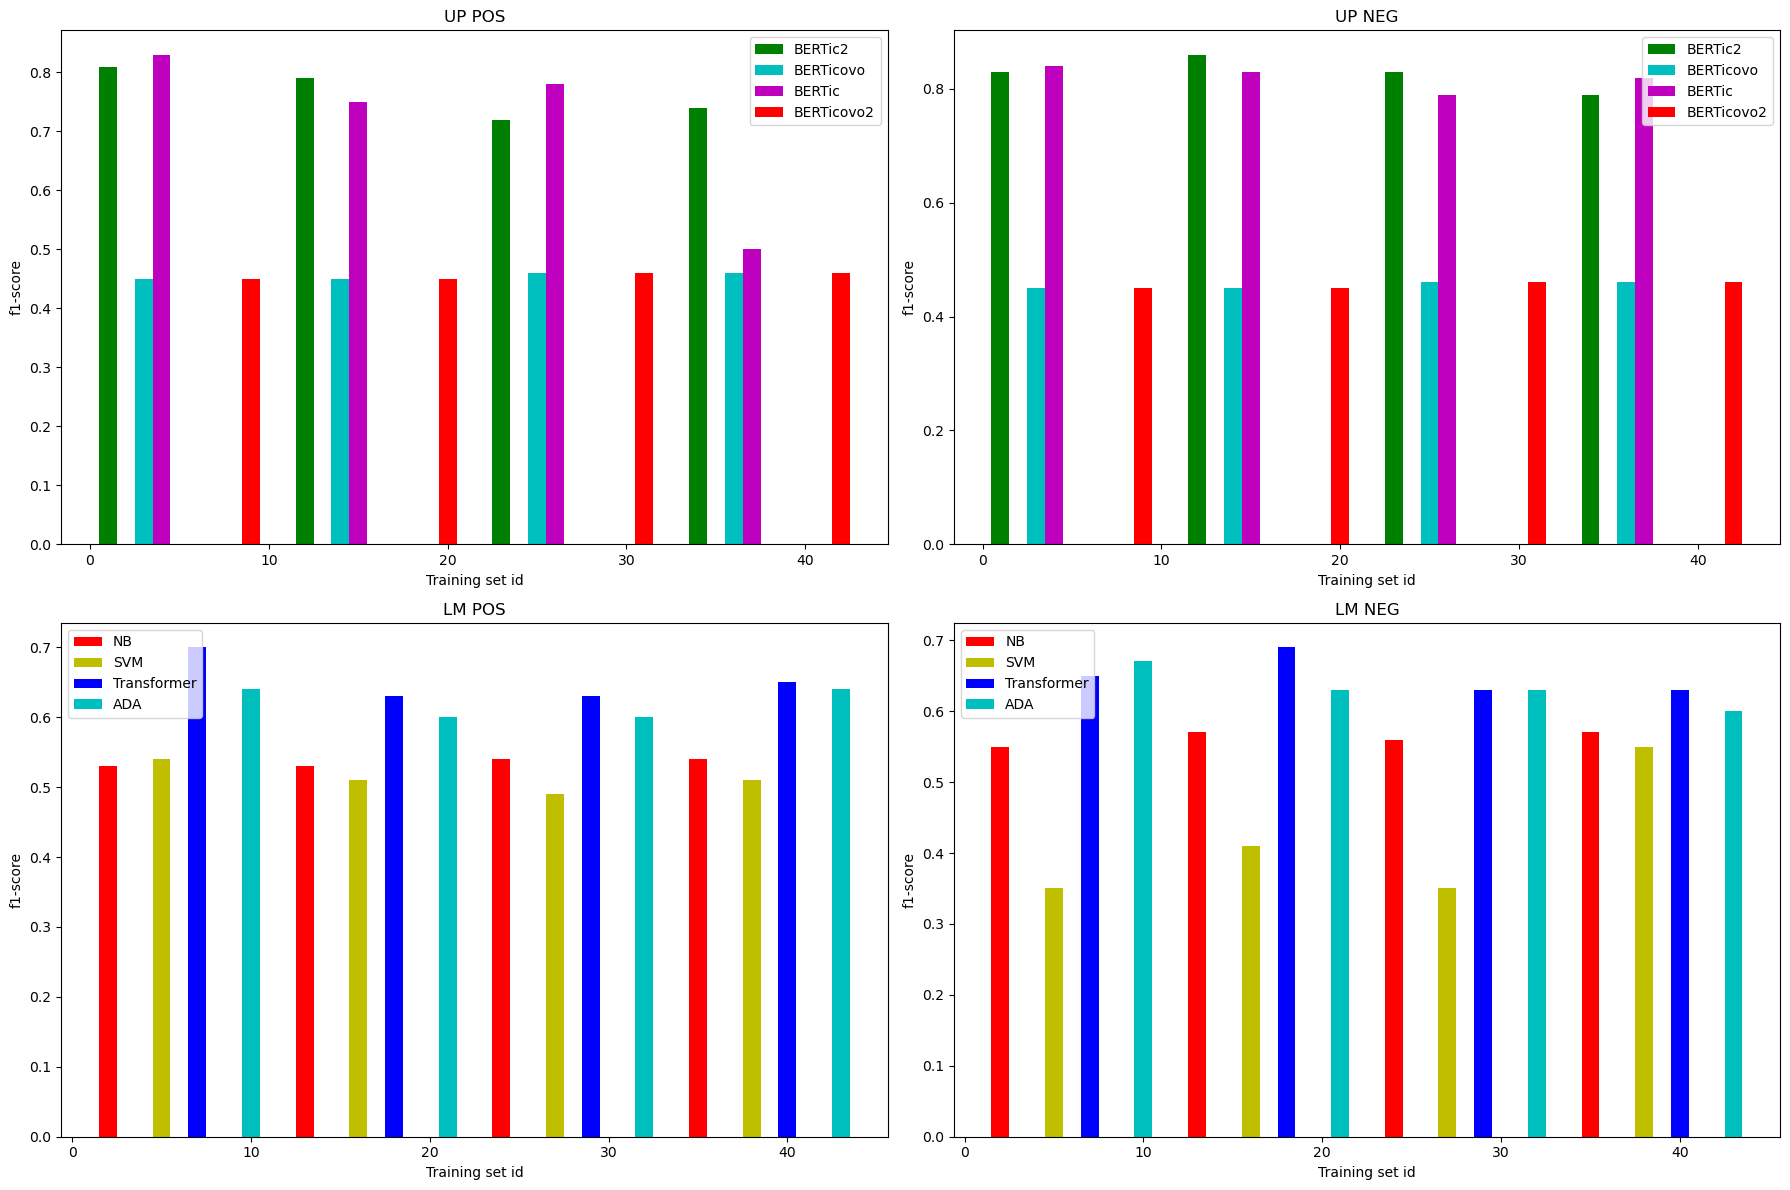

In [23]:
# Load the data from the files
comparison = ReportComparison()
comparison.load_files(REP_DIR)

# Generate the comparison table
table = comparison.generate_table()
print(table)

# Generate the comparison graphs
comparison.generate_graphs('f1-score', 'macro_avg')

In [21]:
table

,model,pre_processing,sentiment,training_set_id,OBJ_precision,OBJ_recall,OBJ_f1-score,NEG_precision,NEG_recall,NEG_f1-score,...,weighted_avg_f1-score,POS_precision,POS_recall,POS_f1-score,0_precision,0_recall,0_f1-score,1_precision,1_recall,1_f1-score
0,ADA,LM,NEG,0.csv.txt,0.99,1.00,0.99,0.48,0.28,0.35,...,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADA,LM,NEG,2.csv.txt,0.99,0.99,0.99,0.33,0.22,0.27,...,0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADA,LM,NEG,4.csv.txt,0.99,0.99,0.99,0.34,0.24,0.28,...,0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADA,LM,NEG,6.csv.txt,0.99,0.99,0.99,0.27,0.18,0.22,...,0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ADA,LM,POS,0.csv.txt,0.99,1.00,1.00,NaN,NaN,NaN,...,0.99,0.4,0.22,0.28,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Transformer,LM,NEG,6.csv.txt,NaN,NaN,NaN,NaN,NaN,NaN,...,0.98,NaN,NaN,NaN,0.99,0.99,0.99,0.32,0.23,0.26
68,Transformer,LM,POS,0.csv.txt,NaN,NaN,NaN,NaN,NaN,NaN,...,0.99,NaN,NaN,NaN,0.99,1.00,1.00,0.77,0.27,0.40
69,Transformer,LM,POS,2.csv.txt,NaN,NaN,NaN,NaN,NaN,NaN,...,0.98,NaN,NaN,NaN,0.99,0.99,0.99,0.30,0.24,0.27
70,Transformer,LM,POS,4.csv.txt,NaN,NaN,NaN,NaN,NaN,NaN,...,0.98,NaN,NaN,NaN,0.99,0.99,0.99,0.33,0.24,0.28


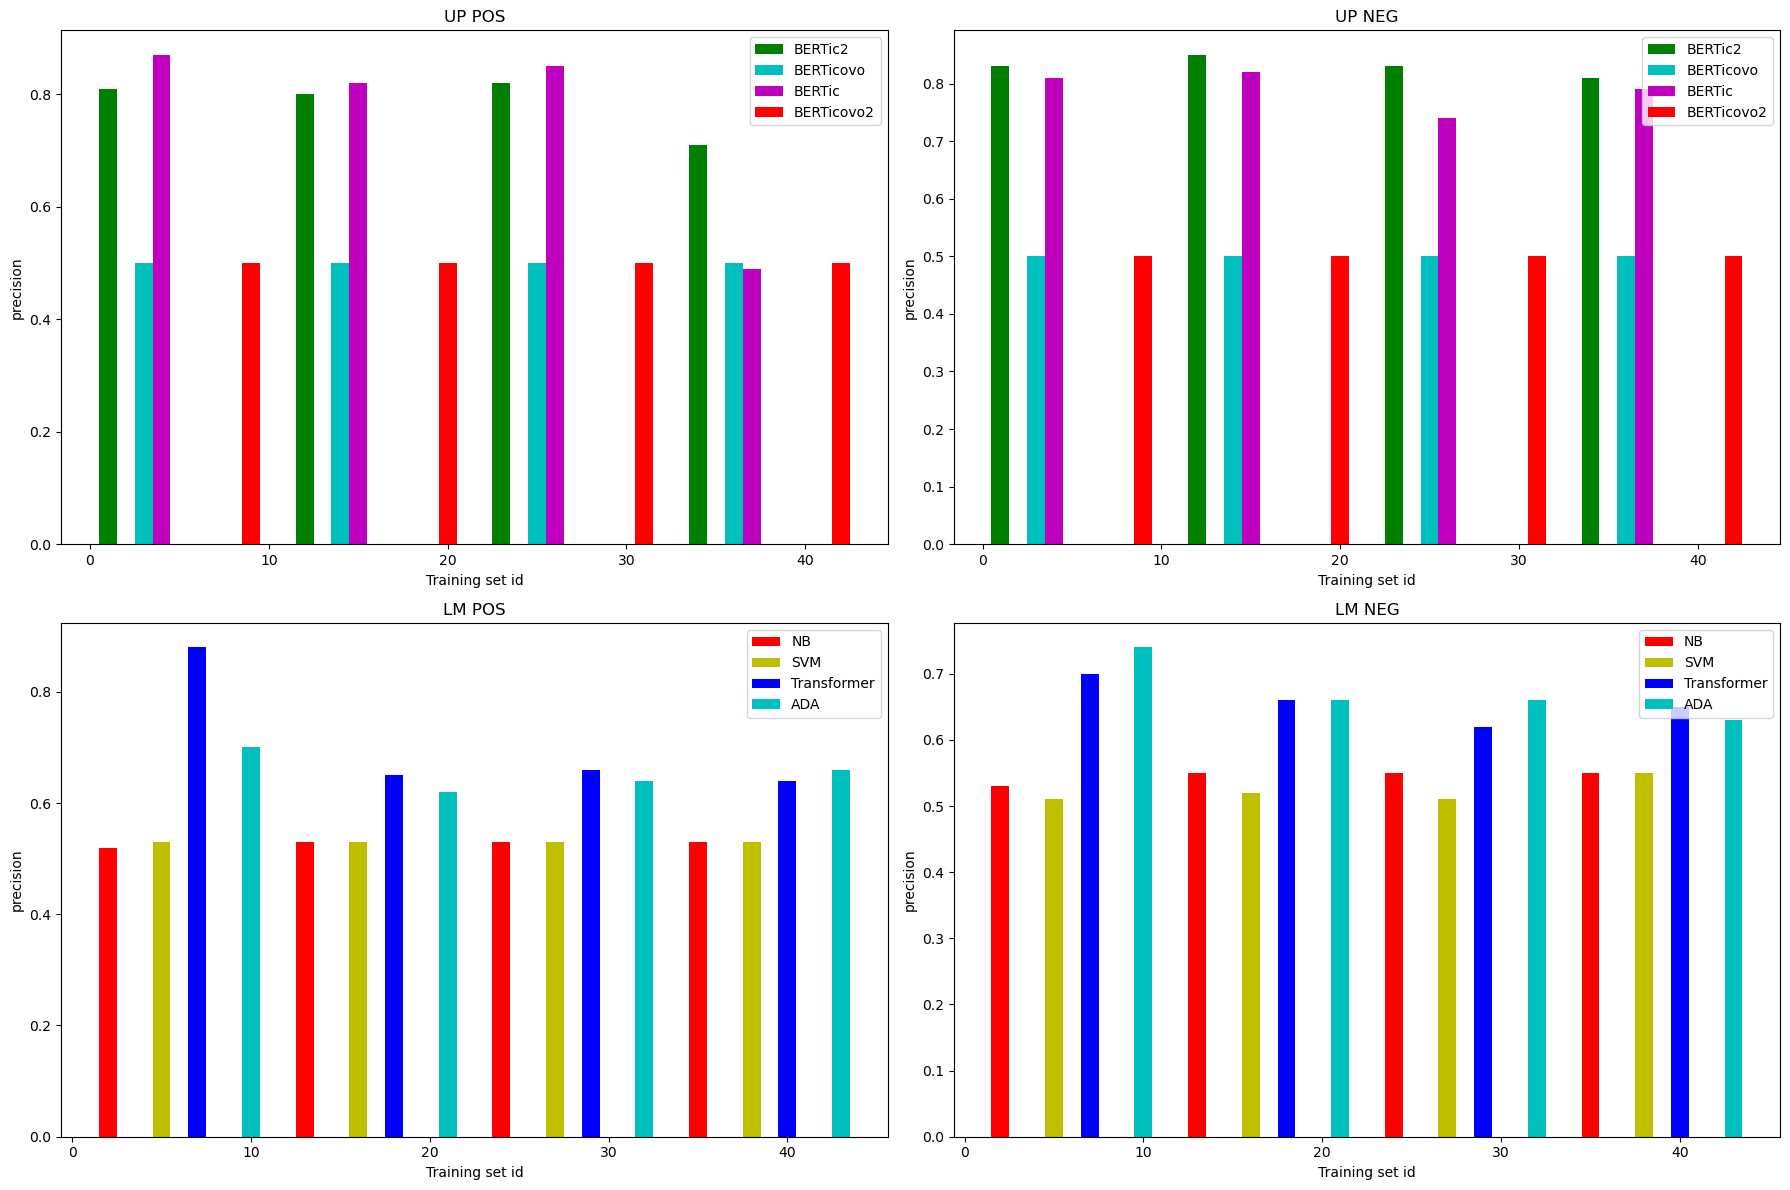

In [24]:
comparison.generate_graphs('precision', 'macro_avg')

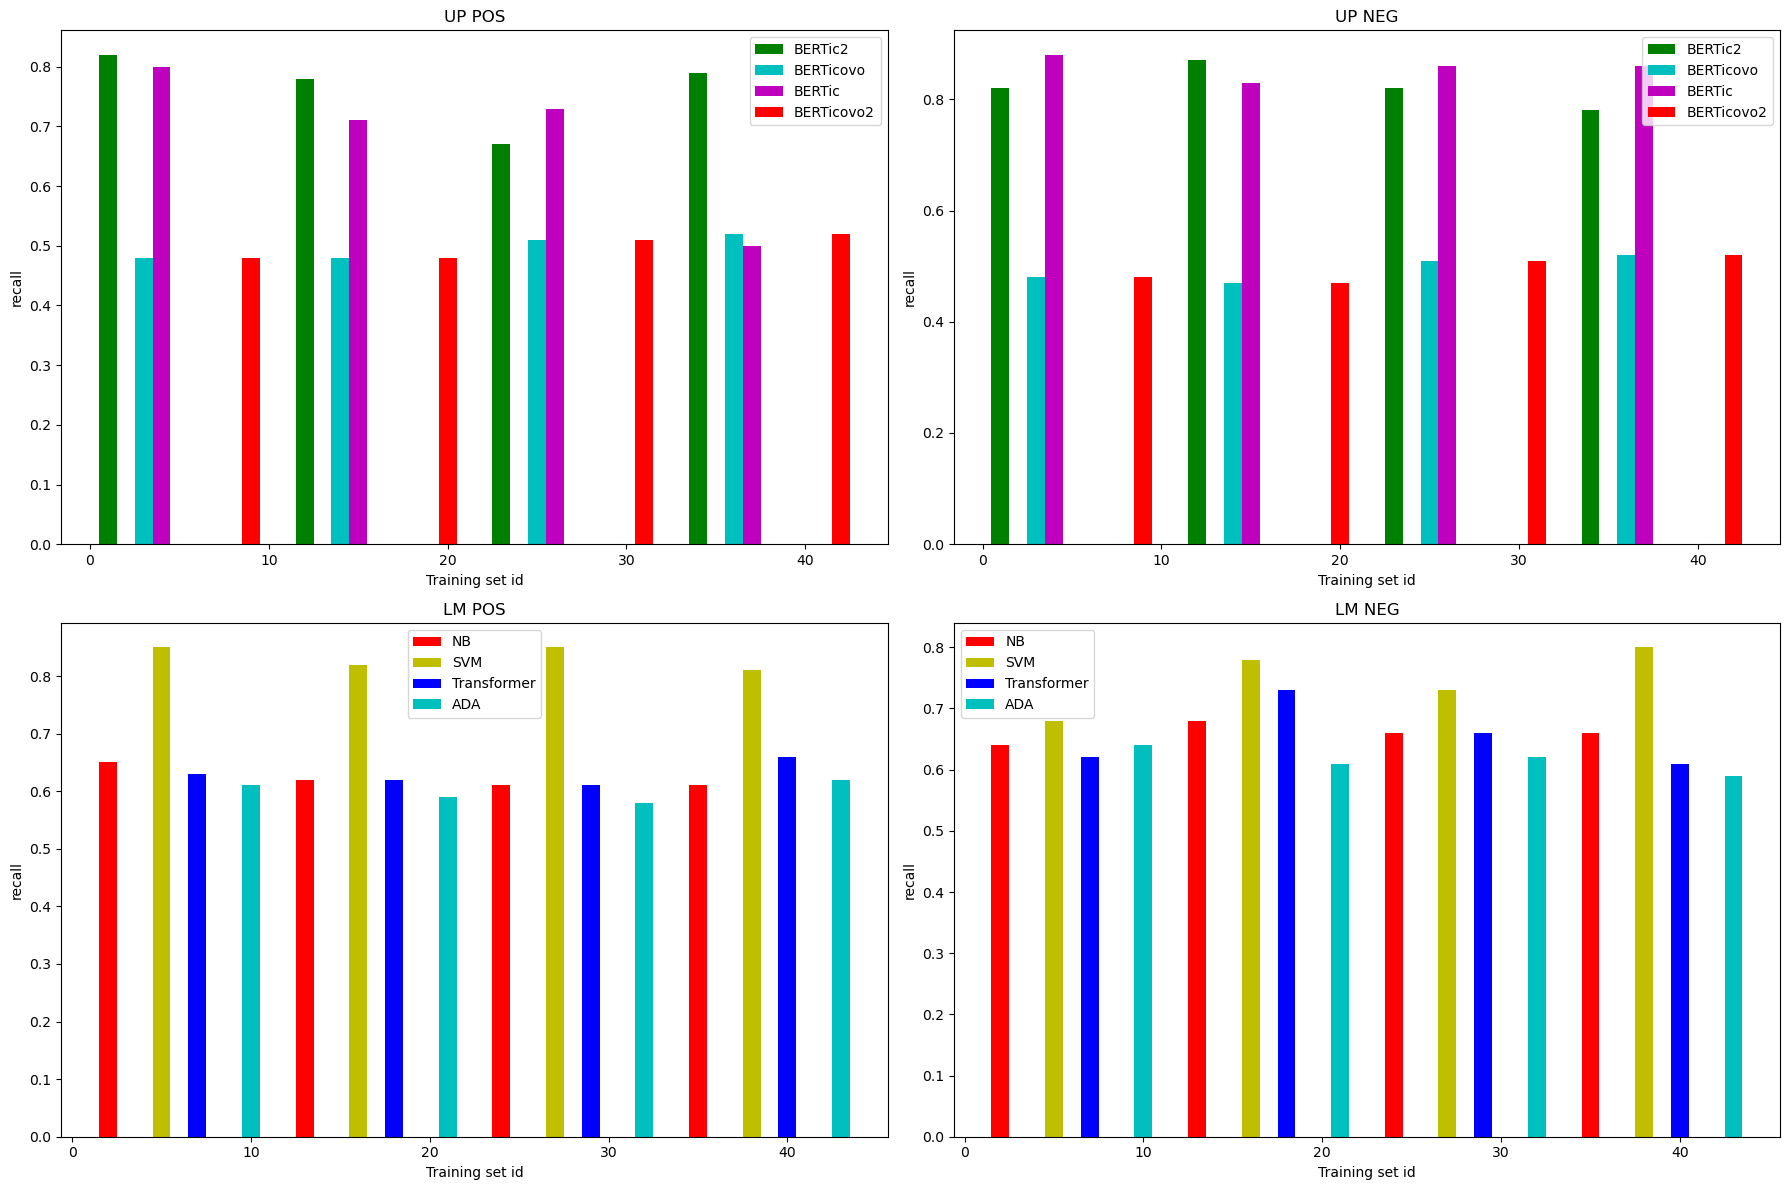

In [25]:
comparison.generate_graphs('recall', 'macro_avg')